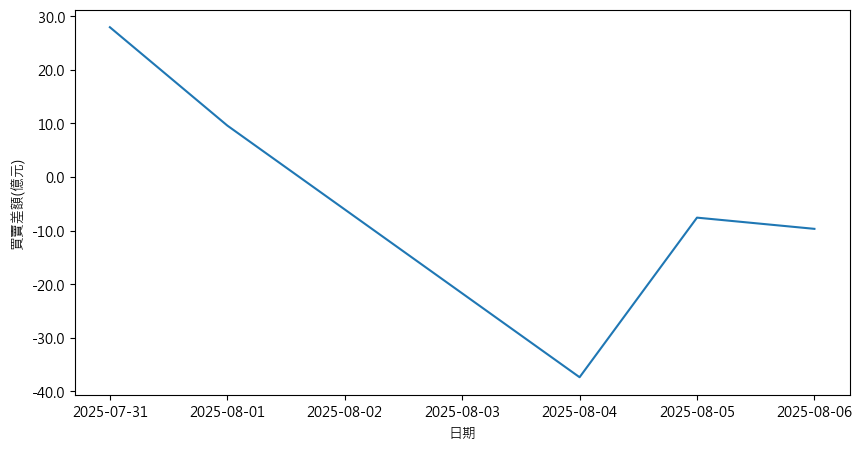

In [ ]:
# 抓取資料外再加上 pandas 的 dataframe 來把多天資料整合在一起，並做成查詢單一單位的折線圖

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import Select
from datetime import date , timedelta
import os
import csv
import pandas
import matplotlib.pyplot as matplot
from matplotlib.ticker import FuncFormatter

driver = webdriver.Chrome()

driver.get("https://www.twse.com.tw/zh/trading/foreign/bfi82u.html")

# 選擇日期的函數

def select_date(date) : 

    select = driver.find_element(By.CLASS_NAME,"selects")

    selects = select.find_elements(By.TAG_NAME,"select")

    year_select = Select(selects[0])
        
    year_select.select_by_value(str(date.year))

    month_select = Select(selects[1])

    month_select.select_by_value(str(date.month))

    day_select = Select(selects[2])

    day_select.select_by_value(str(date.day))

    submit = driver.find_element(By.CLASS_NAME,"submit")

    search = submit.find_element(By.CLASS_NAME,"search")

    search.click()

# 抓取資料的函數

def fetch_data() :

    data = []

    try : 

        wait = WebDriverWait(driver,5)
        wait.until(expected_conditions.visibility_of_element_located((By.TAG_NAME,"table")))

        content = driver.find_element(By.TAG_NAME,"table")

        rows = content.find_elements(By.TAG_NAME,"tr")

        for row in rows : 

            th_rows = row.find_elements(By.TAG_NAME,"th")

            if th_rows : 

                th_row = []

                th_row = [th_cell.text for th_cell in th_rows]

                data.append(th_row)

            td_rows = row.find_elements(By.TAG_NAME,"td")

            if td_rows : 

                td_row = []

                td_row = [td_cell.text for td_cell in td_rows]

                data.append(td_row)

        return data

    except : 

        return data

# 儲存資料的函數

def save_data(path,day,download) : 

    with open(path + f"/{day.year}{day.month:02d}{day.day:02d}.csv","w",encoding="utf-8-sig",newline="") as file : 

        writer = csv.writer(file)

        writer.writerows(download)

# 下載一系列資料的函數

def download_series(Ndays,input_day) :

    N = Ndays

    download_time = 0

    while download_time < N : 

        if input_day.weekday() < 5 : 

            select_date(input_day)

            result = fetch_data()

            if result == [] :

                break
            
            save_data(download_path,input_day,result)

            download_time += 1

        input_day = input_day - timedelta(days=1)

# 執行下載

assign_day = date.today()

download_path = f"download_{assign_day.year}{assign_day.month:02d}{assign_day.day:02d}"

os.makedirs(download_path, exist_ok=True)

download_series(5,assign_day)

# 讀取下載檔案

files = os.listdir(download_path)

all_data = []

for file in files : 

    dataframe = pandas.read_csv(download_path + "/" + file)

    dataframe = dataframe[["單位名稱","買賣差額"]]

    dataframe["日期"] = file.split(".")[0]

    all_data.append(dataframe)

# 把資料合併

combine = pandas.concat(all_data)

# 再把資料調整成適合的型別

combine["日期"] = pandas.to_datetime(combine["日期"])
combine["買賣差額"] = pandas.to_numeric(combine["買賣差額"].str.replace(",","",regex=False))

# 選擇哪一個類別的資料來畫圖

plot = combine[combine["單位名稱"]=="自營商(自行買賣)"]

# 選擇顯示語言

matplot.rcParams["font.family"] = "Microsoft JhengHei"
matplot.rcParams["axes.unicode_minus"] = False

# 選擇 y 軸的單位

def format_y (val,_) : 
    
    return f"{val/1e8:.1f}"

# 畫圖

matplot.figure(figsize=(10,5))
matplot.plot(plot["日期"],plot["買賣差額"])
matplot.gca().yaxis.set_major_formatter(FuncFormatter(format_y))
matplot.xlabel("日期")
matplot.ylabel("買賣差額(億元)")
matplot.show()



In [ ]:
# 按按鈕下載資料的讀取資料部分版本 ( 資料會有其他不必要的資料列，因此要用 skiprow 來讀取 ) 

import os
import pandas
import matplotlib.pyplot as matplot

# 把每一筆資料讀進來後合併

file_set = os.listdir("download")

all_file = []

for file in file_set : 

    # pandas.read_csv 可以用 skiprow 搭配 nrow 選擇要選中間哪幾行

    dataframe = pandas.read_csv("download/"+file,encoding="big5",skiprows=1,nrows=4)

    # 會用 dataframe[ [ "..." , "..." ] ] 這樣架構是因為是 list of list , 資料是分成很多份 , 所以是 [ [ 第一個檔案 ] , [ 第二個檔案 ] ] , 
    # 所以會用 [] 再包住兩個欄位，表示選取各個資料的特定欄位

    new_dataframe = dataframe[["單位名稱","買賣差額"]]

    # split 是依照條件把檔名分割的方法，這邊就是把 "20250801.csv" 拆成 "20250801" , "csv" 再選擇第一個

    new_dataframe["日期"] = file.split(".")[0]

    all_file.append(new_dataframe)

# 把資料合成 dataframe 並作欄位和欄位資料型別調整

combine = pandas.concat(all_file)

# pandas.to_numeric 只認一般格式的數字 , 不會認有逗號的格式 , 因此要用 .string.replace 來把逗號拿掉

combine["日期"] = pandas.to_datetime(combine["日期"])
combine["買賣差額"] = pandas.to_numeric(combine["買賣差額"].str.replace(",","",regex=False))
combine.dropna(subset=["買賣差額"])

plot = combine[combine["單位名稱"]=="投信"].sort_values("日期")

# 畫圖

matplot.figure(figsize=(10,5))
matplot.plot(plot["日期"],plot["買賣差額"])
matplot.xlabel("日期")
matplot.ylabel("買賣差額")
matplot.show()

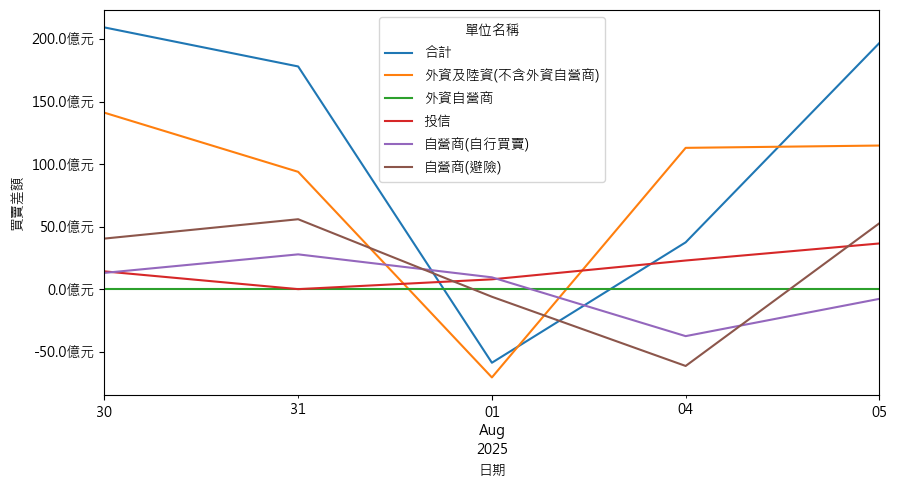

In [ ]:
# 多組資料畫在同一張圖上的版本 ( 合併資料轉成 pivot 型態 )

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import Select
from datetime import date , timedelta
import os
import csv
import pandas
import matplotlib.pyplot as matplot
from matplotlib.ticker import FuncFormatter

download_path = "download_20250805"

# 讀取下載檔案

files = os.listdir(download_path)

all_data = []

for file in files : 

    dataframe = pandas.read_csv(download_path + "/" + file)

    dataframe = dataframe[["單位名稱","買賣差額"]]

    dataframe["日期"] = file.split(".")[0]

    all_data.append(dataframe)

# 把資料合併

combine = pandas.concat(all_data)

# 再把資料調整成適合的型別

combine["日期"] = pandas.to_datetime(combine["日期"])
combine["買賣差額"] = pandas.to_numeric(combine["買賣差額"].str.replace(",","",regex=False))

# 用 .pivot() 來將所有類別資料都顯示在同一張圖上

pivot = combine.pivot(index="日期",columns="單位名稱",values="買賣差額")

# 用 matplot.rcParsms 讓圖表內顯示中文

matplot.rcParams["font.family"] = "Microsoft JhengHei"
matplot.rcParams["axes.unicode_minus"] = False

# 用 matplot.gca().yaxis.set_major_formattor 讓 y 軸顯示想要的單位

def format_y (val,_) : 
    
    return f"{val/1e8:.1f}億元"

# 畫圖

pivot.plot(figsize=(10,5))
matplot.xlabel("日期")
matplot.ylabel("買賣差額")
matplot.gca().yaxis.set_major_formatter(FuncFormatter(format_y))
matplot.show()